<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/master/colab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
!rm -rf vgg16obj
!git clone https://github.com/soukhind2/vgg16obj


Cloning into 'vgg16obj'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 132 (delta 62), reused 61 (delta 25), pack-reused 0
Receiving objects: 100% (132/132), 1.54 MiB | 7.86 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [4]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class

replace data_6class/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools





In [6]:
def convertimgs(path,data) :
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            data.append(im) 
    return data


train_it = []
train_it = convertimgs('/content/data_6class/train/faces/Male',train_it)
train_it = convertimgs('/content/data_6class/train/faces/Female/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Manmade/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Natural/',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Powered',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Nonpowered',train_it)
train_it = np.array(train_it)

val_it = []
val_it = convertimgs('/content/data_6class/val/faces/Male/',val_it)
val_it = convertimgs('/content/data_6class/val/faces/Female/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Manmade/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Natural/',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Powered',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Nonpowered',val_it)
val_it = np.array(val_it)

test_it = []
test_it = convertimgs('/content/data_6class/test/faces/Male/',test_it)
test_it = convertimgs('/content/data_6class/test/faces/Female/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Manmade/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Natural/',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Powered',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Nonowered',test_it)
test_it = np.array(test_it)

print(train_it.shape,val_it.shape,test_it.shape)


(1554, 224, 224, 3) (150, 224, 224, 3) (162, 224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

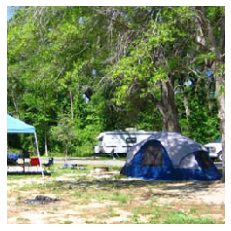

In [7]:
import matplotlib.pyplot as plt
plt.imshow(train_it[800])
plt.axis('off')

In [8]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [244,244,3])
#plot_model(model,show_shapes=True,expand_nested=True)

In [9]:
start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_val = model.predict(val_it) 
print(f'Val Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')

     
#np.save('features_train' , features_train)
#np.save('features_val', features_val)
#np.save('features_test', features_test)

Train Time: 9.87466835975647
Val Time: 1.5199165344238281
Test Time: 0.941561222076416


In [10]:
epochs = 30

#train_data = np.load('features_train.npy')
train_data = features_train
train_labels = to_categorical([0] * 250 + [1]*250 + [2] * 250 + [3] * 250 + [4] * 275 + [5] * 279,6)
train_labels1 = to_categorical([0] * 250 + [1]*250 + [0] * 250 + [1] * 250 + [0] * 275 + [1] * 279,2)
train_labels2 = to_categorical([0] * 250 + [0]*250 + [1] * 250 + [1] * 250 + [2] * 275 + [2] * 279,3)



#val_data = np.load('features_val.npy')
val_data = features_val
val_labels = to_categorical([0] * 25 + [1]*25 + [2] * 25 + [3] * 25 + [4] * 25 + [5] * 25,6)
val_labels1 = to_categorical([0] * 25 + [1]*25 + [0] * 25 + [1] * 25 + [0] * 25 + [1] * 25,2)
val_labels2 = to_categorical([0] * 25 + [0]*25 + [1] * 25 + [1] * 25 + [2] * 25 + [2] * 25,3)


#test_data = np.load('features_test.npy')
test_data = features_test
#test_labels = [0] * 50 + [1] * 50 + [2] * 50
#test_labels = [0] * 61 + [1] * 40 + [2] * 61
test_labels = to_categorical([0] * 31 + [1]*30 + [2] * 19 + [3] * 21 + [4] * 31 + [5] * 30,6)
test_labels1 = to_categorical([0] * 31 + [1]*30 + [0] * 19 + [1] * 21 + [0] * 31 + [1] * 30,2)
test_labels2 = to_categorical([0] * 31 + [0]*30 + [1] * 19 + [1] * 21 + [2] * 31 + [2] * 30,3)
#test_labels = to_categorical(test_labels, 3)


In [ ]:
#@title Automated Branched Model Generation
from vgg16obj.tools import objnet

model = objnet.modelarch().build_full_model([7,7,512],
                                            stem_len = [4096],
                                            b1_len = [1024],
                                            b2_len = [1024])
plot_model(model,show_shapes=True,expand_nested=True)

In [17]:

model = Sequential()

model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(4096, activation='relu')) 
##model.add(Dropout(0.5)) 
#model.add(Dense(4096, activation='relu')) 
model.add(Dense(6, activation='softmax'))

'''losses = {'branch1': 'binary_crossentropy',
          'branch2': 'categorical_crossentropy'}
'''
losses = 'categorical_crossentropy'

model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(x = train_data,  y = train_labels,
          epochs=epochs,
          batch_size=64,
          validation_data=(val_data, val_labels),
          verbose = 1, callbacks = [es])

#model.save_weights('top_weights',overwrite = True)



Epoch 1/30
25/25 [==============================] - 1s 31ms/step - loss: 0.9727 - accuracy: 0.6564 - val_loss: 0.5511 - val_accuracy: 0.8200
Epoch 2/30
25/25 [==============================] - 1s 25ms/step - loss: 0.3612 - accuracy: 0.8835 - val_loss: 0.4505 - val_accuracy: 0.8067
Epoch 3/30
25/25 [==============================] - 1s 25ms/step - loss: 0.2386 - accuracy: 0.9350 - val_loss: 0.4184 - val_accuracy: 0.8267
Epoch 4/30
25/25 [==============================] - 1s 26ms/step - loss: 0.1770 - accuracy: 0.9704 - val_loss: 0.3874 - val_accuracy: 0.8133
Epoch 5/30
25/25 [==============================] - 1s 25ms/step - loss: 0.1361 - accuracy: 0.9839 - val_loss: 0.3950 - val_accuracy: 0.8267
Epoch 00005: early stopping


In [18]:
out = model.evaluate(test_data, test_labels)
print(out)

pred = model.predict(test_data)

#print('rounded test labels',pred)

6/6 [==============================] - 0s 5ms/step - loss: 0.3953 - accuracy: 0.8395
[0.3952772319316864, 0.8395061492919922]


In [13]:
#classes = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
#metric = metrics.classification_report(test_labels,pred,target_names = classes)
#print(metric)


In [ ]:
#@title Branch loss plotting code

lossNames = ["loss", "branch1_loss", "branch2_loss"]
plt.style.use("ggplot")
e = len(history.history['loss'])
(fig, ax) = plt.subplots(1, 3, figsize=(20, 5))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(np.arange(0, e), history.history[l], label=l)
	ax[i].plot(np.arange(0, e), history.history["val_" + l],
		label="validation_" + l)
	ax[i].legend()


Normalized confusion matrix


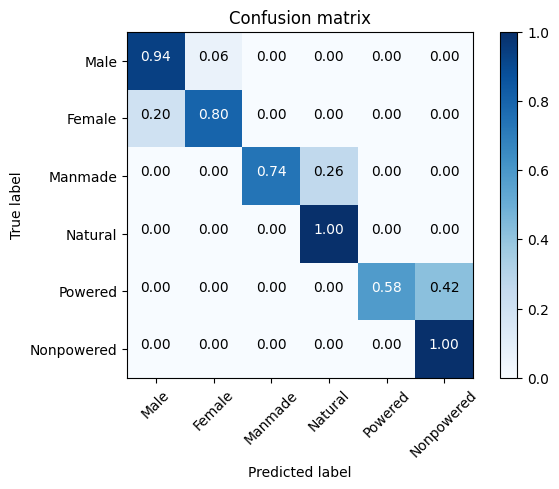

In [19]:
classes = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
#classes = ['Male/ Manmade/ Pwrd','Female/ Natural/ Nonpwrd']
#classes = ['Face', 'Scene','Tool']
plt.style.use('default')

from vgg16obj.tools import plot_tools as pt
#pt.plot_metrics(history)


categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
cm = confusion_matrix(categorical_test_labels, categorical_preds)

pt.plot_confusion_matrix(cm,classes,normalize = True)

In [ ]:
plot_model(model,show_shapes=True,expand_nested=True)

Feature Map Extraction

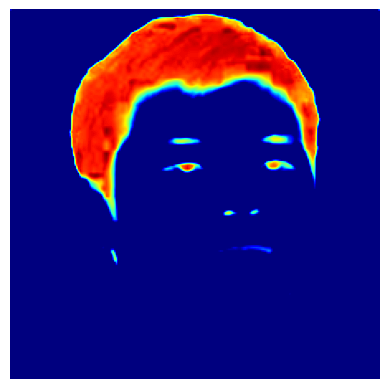

In [20]:
from keras import Model
img_tensor = train_it[0].reshape([1,224,224,3])

model = VGG16(weights='imagenet',
              include_top=False,input_shape = [244,244,3])

layer_outputs = [layer.output for layer in model.layers if 'conv1' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='jet')
plt.axis('off')
plt.show()


Calculating mean activity of feature maps in every layer


In [17]:
from vgg16obj.tools import tun_calc as tc


layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
activation_model = Model(inputs=model.input, outputs=layer_outputs)


start = time.time()

def calc_tun(data,activation_model,layer_names):
    tun_value = [[[] for j in range(len(layer_names))] for i in range(len(data))]
    for imgs,img_tensor in enumerate(data):
      img_tensor = img_tensor.reshape([1,224,224,3])
      intermediate_activations = activation_model.predict(img_tensor)
      for l in range(len(layer_names)):
        layer_activation = intermediate_activations[l]
        for k in range(layer_activation.shape[3]):
          tun_value[imgs][l].append(np.mean(layer_activation[0,:,:,k]))
    return tun_value

tun_value = calc_tun(train_it,activation_model,layer_names)
print(f'Elapsed: {time.time() - start}s')

with open('tuning_values', 'wb') as fp:
    pickle.dump(tun_value, fp)


Elapsed: 276.30232858657837s


##Calcluation of tuning parameters

In [ ]:
with open ('/content/drive/My Drive/obj/outfile', 'rb') as fp:
    tun_value = pickle.load(fp)

In [46]:
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

avg_tun_value = [[0 for item in subl] for subl in tun_value[0]]
for img in range(len(tun_value)):
  tensor_tun = tun_value[img]
  for layer in range(len(tensor_tun)):
    for map in range(len(tensor_tun[layer])):
      avg_tun_value[layer][map] += tensor_tun[layer][map]

avg_tun_value = [[item / 10 for item in subl] for subl in avg_tun_value]

std_tun_value = [[0 for item in subl] for subl in tun_value[0]]
for img in range(len(tun_value)):
  tensor_tun = tun_value[img]
  for layer in range(len(tensor_tun)):
    for map in range(len(tensor_tun[layer])):
      std_tun_value[layer][map] = (tensor_tun[layer][map] - avg_tun_value)**2/len(tun_value)



TypeError: ignored

1554

In [ ]:

layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
fc = np.zeros((6,len(layer_names),600)) #vector for each condition
cat_tun = np.zeros((6,len(layer_names),600)) # average tuning value for each category
labels = np.array([0] * 250 + [1]*250 + [2] * 250 + [3] * 250 + [4] * 275 + [5] * 279)
avg_tun_value = np.mean(tun_value,0)
std_tun_value = np.std(tun_value ,0)

for i in range(6):
  #Calculating average activity of that
  #feature map in response to images of that category, 
  #with the mean activity under all image categories subtracted
  cat_tun[i] = np.mean(tun_value[np.where(labels == i)],0)

for category in range(6):
  for layer in range(fc.shape[0]):
    for map in range(fc.shape[1]):
      if cat_tun[category,layer,map] == 0 or avg_tun_value[layer,map] == 0 or std_tun_value[layer,map] == 0:
        continue
      fc[category,layer,map] = (cat_tun[category,layer,map] - 
                                avg_tun_value[layer,map])/std_tun_value[layer,map]
tun_quality = np.amax(fc,0)
tun_quality = tun_quality[:5,:13]

### Plot tuning quality boxplots

Text(0, 0.5, 'Tuning Quality')

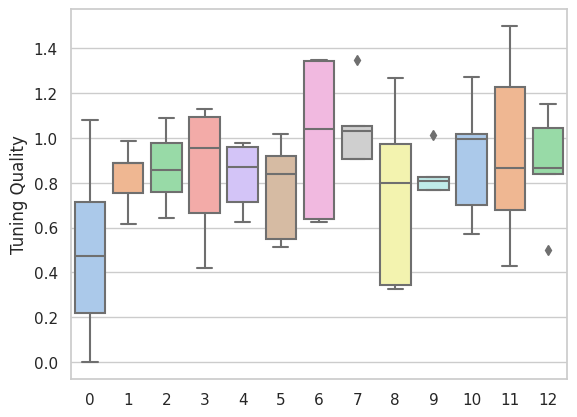

In [109]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_quality,palette='pastel')
ax.set_label('layer')
ax.set_ylabel('Tuning Quality')

### Plot tuning curves


In [118]:
x = np.empty(5)
x[0:4] = 1
x
#np.mean(x)

array([1.        , 1.        , 1.        , 1.        , 0.83727489])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

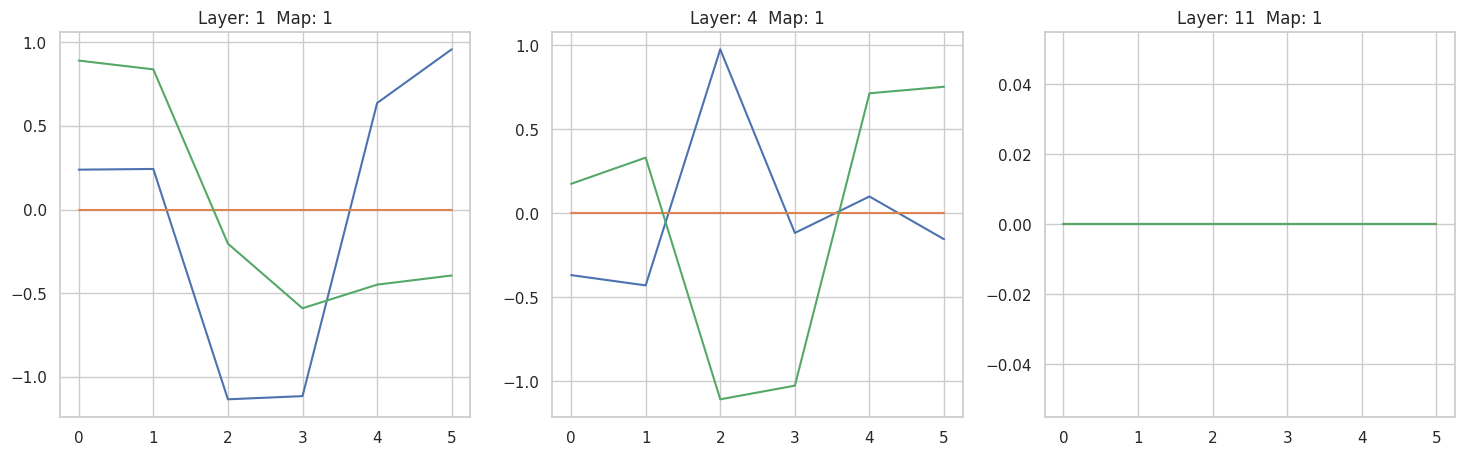

In [98]:
layers = [1,4,11]
maps = [4,18,1]

plt.figure(figsize = (18,5))

for idx,layer in enumerate(layers):
  for map in maps:
    plt.subplot(1,3,idx+1)
    plt.plot(fc[:,layer,map])
    plt.title('Layer: ' + str(layer) + '  Map: ' + str(map))

